# Introduction

This notebook will use the airbnb data cleaned in the directory, to combine the London data with the rest of the uk datasets. The cleaning process will entail:
    
    * Selecting our variables from both datasets. (They need to be matching)-->Missing out on ameneities for London?
    * spatial joining it to LSOA data using geopandas sjoin. LSOA shapefile first needs to added to the IMD data, and other lsoa level data sets
    *machine learning conducted on the final combined datasets
    *Machine learning with bristol and manchester only, which will include the amenities
    *Adding more variables (Journey times to town centre, airport and rail stations)
    *Testing manchester and bristol individually and try some feature engineering
    
    
    https://old.datahub.io/dataset/public-transport-accessibility-levels/resource/77d9b319-931e-4090-bf8e-f578938bd352
    
    https://www.gov.uk/government/statistical-data-sets/acs05-travel-time-destination-and-origin-indicators-to-key-sites-and-services-by-lower-super-output-area-lsoa

In [113]:
import pandas as pd 
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np
import sklearn as sk
import geopandas as gpd

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler, RobustScaler,PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor


from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns

import random
random.seed(123)

# Importing and joining dataframes, and some cleaning

In [2]:
#read in the london data
london_df=pd.read_csv("data//london_detailed.csv")
#read in the Bristol/Manchester data
UK_df=pd.read_csv("uk_airbnb_cleaned.csv")


C:\Python36\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#selecting common columns and the ones we need
columns= ['id','city','latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'price', 
          'number_of_reviews', 'host_is_superhost']

#selecting the columns and concatting
london_df=london_df[columns]
UK_df = UK_df[columns]

#remove $ from london
london_df['price'] = london_df.price.str.replace("\$|,",'').astype(float)


#combing the datasets
combined_df=pd.concat([london_df,UK_df])

In [4]:
#drop nas
combined_df=combined_df.dropna()

In [5]:
combined_df=pd.get_dummies(combined_df, columns=['room_type'])  #OHE the room type and area names. Also convert t/f, to binary
combined_df=combined_df.replace({'t':1, 'f': 0})

# Import the shapefile data, IMD data at LSOA and median house price at lsoa

In [6]:
#read shape file
lsoa_shape=gpd.read_file("data//lsoa_shp//Lower_Layer_Super_Output_Areas__December_2011__Boundaries_Full_Clipped__BFC__EW_V3.shp")

In [7]:
#raed imd and median house price data
imd=pd.read_csv("data//imd.csv")
median_house_price=pd.read_csv("data//median_house_lsoa_2020.csv")

In [8]:
#rename columns in place
imd.rename(columns=({"LSOA code (2011)":"LSOA11CD"}), inplace=True)
median_house_price.rename(columns=({"LSOA code":"LSOA11CD","Year ending Jun 2020": "median_house_price_2020"}), inplace=True)

In [9]:
median_house_price.drop(columns=["Unnamed: 5",'Unnamed: 6'], inplace=True)


In [10]:
median_house_price['median_house_price_2020'] = median_house_price['median_house_price_2020'].str.replace(':','NaN')
median_house_price=median_house_price.dropna() #dropnas 

In [11]:
median_house_price['median_house_price_2020'] = median_house_price['median_house_price_2020'].str.replace(',', '').astype(float) #remove the comma from price

In [12]:
median_house_price

,Local authority code,Local authority name,LSOA11CD,LSOA name,median_house_price_2020
0,E06000001,Hartlepool,E01011949,Hartlepool 009A,84000.0
1,E06000001,Hartlepool,E01011950,Hartlepool 008A,26000.0
2,E06000001,Hartlepool,E01011951,Hartlepool 007A,29425.0
3,E06000001,Hartlepool,E01011952,Hartlepool 002A,66475.0
4,E06000001,Hartlepool,E01011953,Hartlepool 002B,60000.0
...,...,...,...,...,...
34748,W06000024,Merthyr Tydfil,W01001320,Merthyr Tydfil 007C,131000.0
34749,W06000024,Merthyr Tydfil,W01001321,Merthyr Tydfil 007D,88000.0
34750,W06000024,Merthyr Tydfil,W01001322,Merthyr Tydfil 007E,80500.0
34751,W06000024,Merthyr Tydfil,W01001324,Merthyr Tydfil 003E,97000.0


In [13]:
#merge
imd_median_house=imd.merge(median_house_price, on="LSOA11CD")

In [14]:
imd_median_house=imd_median_house[['LSOA11CD','Index of Multiple Deprivation (IMD) Score',
                                  'median_house_price_2020']]  #subset required columns

In [15]:
lsoa_shape=lsoa_shape[['LSOA11CD','LSOA11NM','geometry']] #subset required columns

In [16]:
imd_median_geography=lsoa_shape.merge(imd_median_house, on='LSOA11CD')

# Spatially join airbnb point data and imd and median price data at lsoa level

In [17]:
gdf= gpd.GeoDataFrame(combined_df, geometry=gpd.points_from_xy(combined_df.longitude, combined_df.latitude),
                            crs="EPSG:4326")  #convert to geopandas dataframe


UK_gdf=gdf.to_crs(27700) 

In [18]:
imd_median_geography=imd_median_geography.to_crs(27700) 

In [19]:
UK_gdf=UK_gdf.drop(columns=['latitude','longitude'])

In [20]:
airbnb_with_imd_housep=gpd.sjoin(UK_gdf, imd_median_geography, how="inner", op='within')

# Creating a model with KNN

In [21]:
airbnb_with_imd_housep

,id,city,property_type,accommodates,bathrooms,bedrooms,price,number_of_reviews,host_is_superhost,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,geometry,index_right,LSOA11CD,LSOA11NM,Index of Multiple Deprivation (IMD) Score,median_house_price_2020
0,11551,London,Apartment,4,1.0,1.0,88.0,185,1,1,0,0,0,POINT (530885.122 175377.940),2988,E01003055,Lambeth 016D,34.093,499999.0
3100,1994211,London,Apartment,2,1.0,1.0,43.0,7,0,0,0,1,0,POINT (530763.637 175344.774),2988,E01003055,Lambeth 016D,34.093,499999.0
4015,3160692,London,Loft,5,2.0,2.0,190.0,39,0,1,0,0,0,POINT (530612.157 175288.586),2988,E01003055,Lambeth 016D,34.093,499999.0
4182,3118791,London,Apartment,4,1.0,1.0,80.0,86,1,1,0,0,0,POINT (530848.021 175388.114),2988,E01003055,Lambeth 016D,34.093,499999.0
8204,6407907,London,Apartment,1,1.0,1.0,40.0,1,0,0,0,1,0,POINT (530800.507 175505.958),2988,E01003055,Lambeth 016D,34.093,499999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4843,16361812,Manchester,Private room in house,1,1.0,1.0,45.0,1,0,0,0,1,0,POINT (391153.051 403600.722),5501,E01005381,Oldham 027D,53.441,NaN
4844,44463417,Manchester,Entire apartment,1,1.0,1.0,35.0,11,0,1,0,0,0,POINT (392168.212 404942.869),5470,E01005350,Oldham 014B,75.624,51000.0
4848,30051219,Manchester,Private room in townhouse,1,1.0,1.0,20.0,5,0,0,0,1,0,POINT (389890.850 401432.697),5483,E01005363,Oldham 032A,32.313,125000.0
4851,31168412,Manchester,Private room in house,1,2.0,1.0,50.0,0,0,0,0,1,0,POINT (394026.808 409850.936),5553,E01005441,Oldham 002A,40.000,140000.0


In [22]:
airbnb_with_imd_housep = airbnb_with_imd_housep[airbnb_with_imd_housep['median_house_price_2020'].notna()]


In [23]:
features=airbnb_with_imd_housep[['accommodates', 'bathrooms', 'bedrooms','number_of_reviews', 'host_is_superhost',
       'room_type_Entire home/apt', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Shared room','Index of Multiple Deprivation (IMD) Score', 
                                 'median_house_price_2020']]

target=airbnb_with_imd_housep['price'] #select features and target

In [24]:
scaler=StandardScaler()

features_scaled=scaler.fit_transform(X=features) #scale features

In [25]:
X=features_scaled
y=target


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [26]:
# #knn regressor
# grid_params= {
#     'n_neighbors' :[1,3,5,7,9,12,14,20,40,60,80,100],
#     'weights':['distance','uniform'],
#     'metric': ['minkowski', 'euclidean','manhattan']
# }

# grid = GridSearchCV(KNeighborsRegressor(), grid_params, cv=3, verbose=1, n_jobs=-1)
# grid_result = grid.fit(X_train, y_train)
# print('Best Score: ', grid_result.best_score_)
# print('Best estimator: ', grid_result.best_estimator_)
# print('Best Params: ', grid_result.best_params_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed: 17.4min finished
Best Score:  0.19537267825934715
Best estimator:  KNeighborsRegressor(metric='manhattan', n_neighbors=40)
Best Params:  {'metric': 'manhattan', 'n_neighbors': 40, 'weights': 'uniform'}


# Manchester and Bristol Only

In [27]:
M_B_gdf=airbnb_with_imd_housep[(airbnb_with_imd_housep['city' ] == 'Bristol') | (airbnb_with_imd_housep['city'] == 'Manchester')]

In [28]:
mb_df=pd.read_csv("uk_airbnb_cleaned.csv") #grab amenities


In [29]:
mb_df=mb_df[['id','has_wifi', 'has_kitchen', 'has_parking', 'has_tv','has_washer', 'has_garden', 'has_balcony']] #only keep amenities

In [30]:
mb_df

,id,has_wifi,has_kitchen,has_parking,has_tv,has_washer,has_garden,has_balcony
0,27563570,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,38428583,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,40700904,1.0,1.0,1.0,1.0,1.0,1.0,0.0
3,35818838,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,19871804,1.0,1.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...
4850,43335900,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4851,31168412,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4852,31413465,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4853,42651877,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [31]:
manchester_bristol=M_B_gdf.merge(mb_df, on='id', how='left') #merge amenities to the geodataframe

In [32]:
manchester_bristol.describe()

,id,accommodates,bathrooms,bedrooms,price,number_of_reviews,host_is_superhost,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,...,index_right,Index of Multiple Deprivation (IMD) Score,median_house_price_2020,has_wifi,has_kitchen,has_parking,has_tv,has_washer,has_garden,has_balcony
count,4.597000e+03,4597.000000,4597.000000,4597.000000,4597.000000,4597.000000,4597.000000,4597.000000,4597.000000,4597.000000,...,4597.000000,4597.000000,4.597000e+03,4597.000000,4597.000000,4597.000000,4597.000000,4597.000000,4597.000000,4597.000000
mean,2.762040e+07,3.421579,1.236459,1.564281,83.404394,31.060909,0.284968,0.510768,0.020013,0.459430,...,13384.854253,28.044251,2.427959e+05,0.992386,0.992604,0.992604,0.991734,0.992169,0.992169,0.153361
std,1.372358e+07,2.555518,0.568898,1.154348,170.225404,56.060228,0.451449,0.499938,0.140060,0.498406,...,10498.959081,15.558237,1.116074e+05,0.086933,0.085691,0.085691,0.090552,0.088156,0.088156,0.360374
min,3.952400e+04,1.000000,0.000000,0.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4904.000000,2.403000,5.100000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.604843e+07,2.000000,1.000000,1.000000,35.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,5396.000000,15.672000,1.630000e+05,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
50%,2.990654e+07,2.000000,1.000000,1.000000,56.000000,8.000000,0.000000,1.000000,0.000000,0.000000,...,6279.000000,24.806000,2.225000e+05,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
75%,4.019911e+07,4.000000,1.000000,2.000000,92.000000,35.000000,1.000000,1.000000,0.000000,1.000000,...,14270.000000,37.889000,3.050000e+05,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,4.604304e+07,16.000000,8.000000,30.000000,8000.000000,609.000000,1.000000,1.000000,1.000000,1.000000,...,32777.000000,77.768000,1.195000e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [33]:
#manchester_bristol=manchester_bristol[(manchester_bristol['price']<(83+(170.22*3)))]    #keep prices within 3 s.d

In [34]:
features=manchester_bristol.drop(columns=['id','city', 'property_type','geometry',
       'index_right', 'LSOA11CD', 'LSOA11NM','price'])
target=manchester_bristol['price'] #select features and target

In [35]:
features

,accommodates,bathrooms,bedrooms,number_of_reviews,host_is_superhost,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,Index of Multiple Deprivation (IMD) Score,median_house_price_2020,has_wifi,has_kitchen,has_parking,has_tv,has_washer,has_garden,has_balcony
0,16,3.0,4.0,48,0,1,0,0,0,34.751,199275.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,16,2.0,3.0,13,0,1,0,0,0,34.751,199275.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,16,2.0,3.0,11,0,1,0,0,0,34.751,199275.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
3,16,2.0,3.0,14,0,1,0,0,0,34.751,199275.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,14,2.0,2.0,17,0,1,0,0,0,34.751,199275.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4592,2,1.0,1.0,4,0,0,0,1,0,11.319,244998.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4593,1,1.0,1.0,11,0,1,0,0,0,75.624,51000.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4594,1,1.0,1.0,5,0,0,0,1,0,32.313,125000.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4595,1,2.0,1.0,0,0,0,0,1,0,40.000,140000.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [36]:
scaler=StandardScaler()

features_scaled=scaler.fit_transform(X=features) #scale features

X=features_scaled
y=target


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [37]:
#knn regressor
grid_params= {
    'n_neighbors' :[1,3,5,7,9,12,14,20,40,60,80,100],
    'weights':['distance','uniform'],
    'metric': ['minkowski', 'euclidean','manhattan']
}

grid = GridSearchCV(KNeighborsRegressor(), grid_params, cv=3, verbose=1, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)
print('Best Score: ', grid_result.best_score_)
print('Best estimator: ', grid_result.best_estimator_)
print('Best Params: ', grid_result.best_params_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   18.0s


Best Score:  0.1786848181781815
Best estimator:  KNeighborsRegressor(n_neighbors=100)
Best Params:  {'metric': 'minkowski', 'n_neighbors': 100, 'weights': 'uniform'}


[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:   20.1s finished


In [38]:
#knn is our most accurate model, lets see the root mean squared error
knn=KNeighborsRegressor(metric='manhattan', n_neighbors=3, weights='distance')

knn=knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

mse= mean_squared_error(y_test, y_pred)
rmse=mse**(1/2)
rmse   

185.27473458102753

In [39]:
#ridge regression
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = dict(alpha=alpha)
grid = GridSearchCV(estimator=Ridge(), param_grid=param_grid, scoring='r2', verbose=1, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)
print('Best Score: ', grid_result.best_score_)
print('Best estimator: ', grid_result.best_estimator_)
print('Best Params: ', grid_result.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Score:  0.2977925182788754
Best estimator:  Ridge(alpha=10)
Best Params:  {'alpha': 10}


[Parallel(n_jobs=-1)]: Done  20 out of  35 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.2s finished


In [40]:
#lasso regression
# find optimal alpha with grid search
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = dict(alpha=alpha)
grid = GridSearchCV(estimator=Lasso(), param_grid=param_grid, scoring='r2', verbose=1, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)
print('Best estimator: ', grid_result.best_estimator_)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best Score:  0.29858710283448026
Best Params:  {'alpha': 1}
Best estimator:  Lasso(alpha=1)


[Parallel(n_jobs=-1)]: Done  20 out of  35 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.2s finished


In [41]:
#linear regression
grid_params= {'fit_intercept':('True', 'False'), 'normalize':('True', 'False'), 'copy_X':('True', 'False')}

grid = GridSearchCV(LinearRegression(), param_grid=grid_params, cv=None)
grid_result = grid.fit(X_train, y_train)
print ("r2 / variance : ", grid.best_score_)
print('Best Score: ', grid_result.best_score_)
print('Best estimator: ', grid_result.best_estimator_)
print('Best Params: ', grid_result.best_params_)


r2 / variance :  -5.0104016063572826e+23
Best Score:  -5.0104016063572826e+23
Best estimator:  LinearRegression(copy_X='True', fit_intercept='True', normalize='True')
Best Params:  {'copy_X': 'True', 'fit_intercept': 'True', 'normalize': 'True'}


In [42]:
#knn is our most accurate model, lets see the root mean squared error
ridge=Ridge(alpha=0.001)

ridge=ridge.fit(X_train, y_train)

y_pred = ridge.predict(X_test)

mse= mean_squared_error(y_test, y_pred)
rmse=mse**(1/2)
rmse   

183.45483720740592

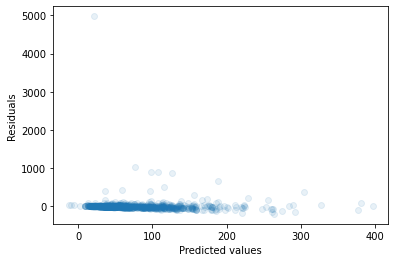

In [43]:
residuals = y_test-y_pred
plt.scatter(y_pred,residuals, alpha=0.1)
plt.ylabel("Residuals")
plt.xlabel("Predicted values")


plt.show()

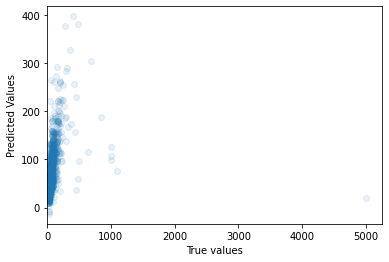

In [44]:
plt.scatter(y_test,y_pred,alpha=0.1)
plt.ylabel("Predicted Values")
plt.xlabel("True values")
plt.xlim(xmin=0)
plt.show()

# Adding new variables (Journey time to town centre,airport, rail stations by public transport/walking) from DfT

In [45]:
journey_town=pd.read_csv("data//journey_data//min_town_centre_ptw.csv")
journey_station=pd.read_csv("data//journey_data//avg_time_rail_station_ptw.csv")
journey_airport=pd.read_csv("data//journey_data//avg_time_airport_ptw.csv")

In [46]:
#subset columns and change column name
#town
journey_town=journey_town.rename(columns=({'mins_nearest_town_pubt_walk':'minutes_to_town', 'LSOA_code': 'LSOA Code'}))
journey_town=journey_town[['LSOA Code','minutes_to_town']]
#station
journey_station=journey_station.rename(columns=({'Average travel time to rail station(minutes)':'minutes_to_rail'}))
journey_station=journey_station[['LSOA Code','minutes_to_rail']]
#airport
journey_airport=journey_airport.rename(columns=({'Average minimum journey time (minutes)':'minutes_to_airport'}))
journey_airport=journey_airport[['LSOA Code','minutes_to_airport']]

In [47]:
journey_dfs=[journey_town,journey_station,journey_airport]

df_all_journeys=reduce(lambda left,right: pd.merge(left,right,on='LSOA Code'), journey_dfs)
df_all_journeys=df_all_journeys.rename(columns=({'LSOA Code': 'LSOA11CD'}))

In [48]:
df_all_journeys

,LSOA11CD,minutes_to_town,minutes_to_rail,minutes_to_airport
0,E01000001,23,16,46
1,E01000002,22,12,43
2,E01000003,22,20,50
3,E01000005,21,7,42
4,E01000006,10,8,40
...,...,...,...,...
32839,E01033764,15,19,53
32840,E01033765,21,22,36
32841,E01033766,12,28,36
32842,E01033767,24,24,40


# Adding and seeing the impact of this new variable

In [49]:
manchester_bristol_journey=manchester_bristol.merge(df_all_journeys, on='LSOA11CD', how='left')

In [50]:
# sns.pairplot(data=manchester_bristol_journey.sample(400),hue='city')
# plt.show()

In [51]:
manchester_bristol_journey_stdp=manchester_bristol_journey[manchester_bristol_journey['number_of_reviews']>7]

In [52]:
manchester_bristol_journey_stdp=manchester_bristol_journey[(manchester_bristol_journey['price']<(83+(170*3)))] #price within ~3sd

In [53]:
manchester_bristol_journey_stdp['logreviews']=np.log(1+ manchester_bristol_journey_stdp['number_of_reviews'])


C:\Python36\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [54]:
features=manchester_bristol_journey_stdp.drop(columns=['id','city', 'property_type','geometry',
       'index_right', 'LSOA11CD', 'LSOA11NM','price','number_of_reviews'])
target=manchester_bristol_journey_stdp['price'] #select features and target

In [55]:
scaler=StandardScaler()

features_scaled=scaler.fit_transform(X=features) #scale features

X=features_scaled
y=target


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [56]:
#knn regressor
grid_params= {
    'n_neighbors' :[1,3,5,7,9,12,14,20,40,60,80,100],
    'weights':['distance','uniform'],
    'metric': ['minkowski', 'euclidean','manhattan']
}

grid = GridSearchCV(KNeighborsRegressor(), grid_params, cv=3, verbose=1, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)
print('Best Score: ', grid_result.best_score_)
print('Best estimator: ', grid_result.best_estimator_)
print('Best Params: ', grid_result.best_params_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.5s


Best Score:  0.48620983708066606
Best estimator:  KNeighborsRegressor(metric='manhattan', n_neighbors=14, weights='distance')
Best Params:  {'metric': 'manhattan', 'n_neighbors': 14, 'weights': 'distance'}


[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:   12.6s finished


In [57]:
#knn is our most accurate model, lets see the root mean squared error
knn= KNeighborsRegressor(metric='manhattan', n_neighbors=20, weights='distance')

knn=knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

mse= mean_squared_error(y_test, y_pred)
rmse=mse**(1/2)
rmse   

48.39854611785508

# Manchester Only

In [58]:
manchester_only=manchester_bristol_journey[manchester_bristol_journey['city']=='Manchester']


In [59]:
manchester_only=manchester_only[manchester_only['number_of_reviews']>7]

In [60]:
manchester_only=manchester_only[(manchester_only['price']<(70+(75*3)))] #price within 3sd

In [61]:
manchester_only

,id,city,property_type,accommodates,bathrooms,bedrooms,price,number_of_reviews,host_is_superhost,room_type_Entire home/apt,...,has_wifi,has_kitchen,has_parking,has_tv,has_washer,has_garden,has_balcony,minutes_to_town,minutes_to_rail,minutes_to_airport
6,8519213,Manchester,Apartment,14,2.0,3.0,150.0,30,0,1,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,9,17,39
12,6803039,Manchester,Apartment,8,1.0,3.0,150.0,10,0,1,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,9,17,39
16,27873592,Manchester,Entire house,6,2.0,3.0,93.0,86,0,1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,9,17,39
18,28580121,Manchester,Entire apartment,6,1.0,2.0,65.0,42,0,1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,9,17,39
19,17506982,Manchester,Entire apartment,6,1.0,2.0,63.0,179,0,1,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,9,17,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4565,37525503,Manchester,Entire guest suite,2,1.0,1.0,70.0,81,1,1,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,10,52,96
4569,32435340,Manchester,Private room in house,1,1.0,1.0,25.0,9,1,0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,10,55,85
4581,7384836,Manchester,Private room in house,1,1.0,1.0,25.0,9,0,0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,18,31,70
4589,31413465,Manchester,Private room in house,1,1.0,1.0,14.0,9,1,0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,5,56,86


In [62]:
manchester_only['logreviews']=np.log(1+ manchester_only['number_of_reviews'])
#manchester_only['bedrooms_per_accomodates']=manchester_only['bedrooms']/manchester_only['accommodates']

In [63]:
features=manchester_only.drop(columns=['id','city', 'property_type','geometry',
       'index_right', 'LSOA11CD', 'LSOA11NM','price','number_of_reviews'])
target=manchester_only['price'] #select features and target


scaler=StandardScaler()

features_scaled=scaler.fit_transform(X=features) #scale features

X=features_scaled
y=target


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


#knn regressor
grid_params= {
    'n_neighbors' :[1,3,5,7,9,12,14,20,40,60,80,100],
    'weights':['distance','uniform'],
    'metric': ['minkowski', 'euclidean','manhattan']
}

grid = GridSearchCV(KNeighborsRegressor(), grid_params, cv=3, verbose=1, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)
print('Best Score: ', grid_result.best_score_)
print('Best estimator: ', grid_result.best_estimator_)
print('Best Params: ', grid_result.best_params_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.6s


Best Score:  0.5711896023636448
Best estimator:  KNeighborsRegressor(metric='manhattan', n_neighbors=20, weights='distance')
Best Params:  {'metric': 'manhattan', 'n_neighbors': 20, 'weights': 'distance'}


[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:    2.1s finished


In [64]:
#ridge regression
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = dict(alpha=alpha)
grid = GridSearchCV(estimator=Ridge(), param_grid=param_grid, scoring='r2', verbose=1, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)
print('Best Score: ', grid_result.best_score_)
print('Best estimator: ', grid_result.best_estimator_)
print('Best Params: ', grid_result.best_params_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done  20 out of  35 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.1s finished


Best Score:  0.6063260371299657
Best estimator:  Ridge(alpha=100)
Best Params:  {'alpha': 100}


In [65]:
#knn is our most accurate model, lets see the root mean squared error
knn= KNeighborsRegressor(metric='manhattan', n_neighbors=20, weights='distance')

knn=knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

mse= mean_squared_error(y_test, y_pred)
rmse=mse**(1/2)
rmse   

28.55278982598983

# Bristol

In [66]:
bristol_only=manchester_bristol_journey[manchester_bristol_journey['city']=='Bristol']


In [67]:
bristol_only=bristol_only[bristol_only['number_of_reviews']>7]

In [68]:
bristol_only=bristol_only[(bristol_only['price']<(89+(113*3)))] #price within 3sd
bristol_only['logreviews']=np.log(1+ bristol_only['number_of_reviews'])


In [69]:
features=bristol_only.drop(columns=['id','city', 'property_type','geometry',
       'index_right', 'LSOA11CD', 'LSOA11NM','price','number_of_reviews'])
target=bristol_only['price'] #select features and target


scaler=StandardScaler()

features_scaled=scaler.fit_transform(X=features) #scale features

X=features_scaled
y=target



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


#knn regressor
grid_params= {
    'n_neighbors' :[1,3,5,7,9,12,14,20,40,60,80,100],
    'weights':['distance','uniform'],
    'metric': ['minkowski', 'euclidean','manhattan']
}

grid = GridSearchCV(KNeighborsRegressor(), grid_params, cv=3, verbose=1, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)
print('Best Score: ', grid_result.best_score_)
print('Best estimator: ', grid_result.best_estimator_)
print('Best Params: ', grid_result.best_params_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s


Best Score:  0.6491460398468982
Best estimator:  KNeighborsRegressor(n_neighbors=9, weights='distance')
Best Params:  {'metric': 'minkowski', 'n_neighbors': 9, 'weights': 'distance'}


[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:    1.0s finished


In [70]:
#knn is our most accurate model, lets see the root mean squared error
knn= KNeighborsRegressor(metric='manhattan', n_neighbors=12, weights='distance')

knn=knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

mse= mean_squared_error(y_test, y_pred)
rmse=mse**(1/2)
rmse   

33.8795906361902

In [71]:
#lasso regression
# find optimal alpha with grid search
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = dict(alpha=alpha)
grid = GridSearchCV(estimator=Lasso(), param_grid=param_grid, scoring='r2', verbose=1, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)
print('Best estimator: ', grid_result.best_estimator_)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best Score: 

[Parallel(n_jobs=-1)]: Done  20 out of  35 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.1s finished


 0.682281522485386
Best Params:  {'alpha': 1}
Best estimator:  Lasso(alpha=1)


In [72]:
#knn is our most accurate model, lets see the root mean squared error
lasso= Lasso(alpha=1)

lasso=lasso.fit(X_train,y_train)

y_pred = lasso.predict(X_test)

mse= mean_squared_error(y_test, y_pred)
rmse=mse**(1/2)
rmse   

35.03648994060183

#####  Brisotol XGboost Random forest

In [73]:
import xgboost
from xgboost import XGBRFRegressor


In [74]:
from sklearn.ensemble import RandomForestRegressor


rfr=XGBRFRegressor(learning_rate=1,n_jobs=-1)


rfr.fit(X_train,y_train)


y_pred = rfr.predict(X_test)

mse= mean_squared_error(y_test, y_pred)
rmse=mse**(1/2)
rmse 

32.70351417878007

## Model with 800 samples from bristol and manchester. This model will then be tested with the withheld data

In [104]:
sampled_bristol_machester=manchester_bristol_journey.copy()
sampled_bristol_machester=sampled_bristol_machester[sampled_bristol_machester['number_of_reviews']>7]

In [105]:
sampled_bristol_machester

,id,city,property_type,accommodates,bathrooms,bedrooms,price,number_of_reviews,host_is_superhost,room_type_Entire home/apt,...,has_wifi,has_kitchen,has_parking,has_tv,has_washer,has_garden,has_balcony,minutes_to_town,minutes_to_rail,minutes_to_airport
0,27563570,Manchester,Entire apartment,16,3.0,4.0,454.0,48,0,1,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,9,17,39
1,27153600,Manchester,Entire apartment,16,2.0,3.0,640.0,13,0,1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,9,17,39
2,27041971,Manchester,Entire apartment,16,2.0,3.0,439.0,11,0,1,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,9,17,39
3,30371210,Manchester,Entire apartment,16,2.0,3.0,454.0,14,0,1,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,9,17,39
4,27300113,Manchester,Entire apartment,14,2.0,2.0,336.0,17,0,1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,9,17,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4565,37525503,Manchester,Entire guest suite,2,1.0,1.0,70.0,81,1,1,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,10,52,96
4569,32435340,Manchester,Private room in house,1,1.0,1.0,25.0,9,1,0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,10,55,85
4581,7384836,Manchester,Private room in house,1,1.0,1.0,25.0,9,0,0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,18,31,70
4589,31413465,Manchester,Private room in house,1,1.0,1.0,14.0,9,1,0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,5,56,86


In [106]:
sampled_bristol_machester=sampled_bristol_machester[(sampled_bristol_machester['price']<=1000) & (sampled_bristol_machester['price']>=15)] #price within 3sd
#what price should we use???

In [107]:
sampled_bristol_machester

,id,city,property_type,accommodates,bathrooms,bedrooms,price,number_of_reviews,host_is_superhost,room_type_Entire home/apt,...,has_wifi,has_kitchen,has_parking,has_tv,has_washer,has_garden,has_balcony,minutes_to_town,minutes_to_rail,minutes_to_airport
0,27563570,Manchester,Entire apartment,16,3.0,4.0,454.0,48,0,1,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,9,17,39
1,27153600,Manchester,Entire apartment,16,2.0,3.0,640.0,13,0,1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,9,17,39
2,27041971,Manchester,Entire apartment,16,2.0,3.0,439.0,11,0,1,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,9,17,39
3,30371210,Manchester,Entire apartment,16,2.0,3.0,454.0,14,0,1,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,9,17,39
4,27300113,Manchester,Entire apartment,14,2.0,2.0,336.0,17,0,1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,9,17,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4561,27322564,Manchester,Entire apartment,2,1.0,1.0,36.0,13,0,1,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,11,35,66
4565,37525503,Manchester,Entire guest suite,2,1.0,1.0,70.0,81,1,1,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,10,52,96
4569,32435340,Manchester,Private room in house,1,1.0,1.0,25.0,9,1,0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,10,55,85
4581,7384836,Manchester,Private room in house,1,1.0,1.0,25.0,9,0,0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,18,31,70


In [108]:
sampled_bristol_machester=sampled_bristol_machester.groupby('city').apply(lambda x: x.sample(800)) #tale 400 of each city
sampled_bristol_machester=sampled_bristol_machester.reset_index(drop='city')

In [109]:
sampled_bristol_machester.describe()

,id,accommodates,bathrooms,bedrooms,price,number_of_reviews,host_is_superhost,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,...,Index of Multiple Deprivation (IMD) Score,median_house_price_2020,has_wifi,has_kitchen,has_parking,has_tv,has_washer,has_garden,has_balcony,minutes_to_town
count,1.600000e+03,1600.000000,1600.000000,1600.00000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,...,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.00000
mean,2.292488e+07,3.414375,1.215000,1.55000,75.407500,61.441250,0.440625,0.553750,0.029375,0.413750,...,26.183393,274611.912500,0.998750,0.998750,0.998750,0.998750,0.998750,0.998750,0.219375,14.58500
std,1.206975e+07,2.422568,0.541314,1.01951,80.134347,71.832637,0.496617,0.497258,0.168908,0.492659,...,15.254603,116952.737423,0.035344,0.035344,0.035344,0.035344,0.035344,0.035344,0.413953,5.74573
min,7.082000e+04,1.000000,0.000000,0.00000,15.000000,8.000000,0.000000,0.000000,0.000000,0.000000,...,2.403000,60000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.00000
25%,1.411267e+07,2.000000,1.000000,1.00000,35.000000,17.000000,0.000000,0.000000,0.000000,0.000000,...,14.321500,189500.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,10.00000
50%,2.305974e+07,2.000000,1.000000,1.00000,56.000000,35.000000,0.000000,1.000000,0.000000,0.000000,...,23.103000,250000.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,14.00000
75%,3.318185e+07,4.000000,1.000000,2.00000,86.000000,74.000000,1.000000,1.000000,0.000000,1.000000,...,35.556000,346581.750000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,19.00000
max,4.528601e+07,16.000000,8.000000,12.00000,1000.000000,609.000000,1.000000,1.000000,1.000000,1.000000,...,75.035000,790000.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,35.00000


In [110]:
sampled_bristol_machester['logreviews']=np.log(1+ sampled_bristol_machester['number_of_reviews'])


In [111]:
features=sampled_bristol_machester.drop(columns=['id','city', 'property_type','geometry',
       'index_right', 'LSOA11CD', 'LSOA11NM','price','number_of_reviews'])
target=sampled_bristol_machester['price'] #select features and target


scaler=StandardScaler()

features_scaled=scaler.fit_transform(X=features) #scale features

X=features_scaled
y=target


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


#knn regressor
grid_params= {
    'n_neighbors' :[1,3,5,7,9,12,14,20,40,60,80,100],
    'weights':['distance','uniform'],
    'metric': ['minkowski', 'euclidean','manhattan']
}

grid = GridSearchCV(KNeighborsRegressor(), grid_params, cv=3, verbose=1, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)
print('Best Score: ', grid_result.best_score_)
print('Best estimator: ', grid_result.best_estimator_)
print('Best Params: ', grid_result.best_params_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.3s


Best Score:  0.5324765463888559
Best estimator:  KNeighborsRegressor(n_neighbors=9, weights='distance')
Best Params:  {'metric': 'minkowski', 'n_neighbors': 9, 'weights': 'distance'}


[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:    8.7s finished


In [114]:
# find optimal alpha with grid search
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = dict(alpha=alpha)
grid = GridSearchCV(estimator=Lasso(), param_grid=param_grid, scoring='r2', verbose=1, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)
print('Best estimator: ', grid_result.best_estimator_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best Score:  0.5455478860644216
Best Params:  {'alpha': 1}
Best estimator:  Lasso(alpha=1)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  35 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.1s finished


In [115]:
#knn is our most accurate model, lets see the root mean squared error
knn= KNeighborsRegressor(metric='manhattan', n_neighbors=12, weights='distance')

knn=knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

mse= mean_squared_error(y_test, y_pred)
rmse=mse**(1/2)
rmse   

81.42112015833116

In [116]:
#Lasso RMSE
Lasso= Lasso(alpha=0.1)

Lasso=Lasso.fit(X_train, y_train)

y_pred = Lasso.predict(X_test)

mse= mean_squared_error(y_test, y_pred)
rmse=mse**(1/2)
rmse   

78.29604714094452

Feature: 0, Score: 38.24644
Feature: 1, Score: 5.82411
Feature: 2, Score: 5.53740
Feature: 3, Score: 0.92821
Feature: 4, Score: 2.04171
Feature: 5, Score: 0.00000
Feature: 6, Score: -3.90586
Feature: 7, Score: -0.63547
Feature: 8, Score: -4.84426
Feature: 9, Score: 5.48125
Feature: 10, Score: -0.15227
Feature: 11, Score: -0.00000
Feature: 12, Score: -0.00000
Feature: 13, Score: -0.00000
Feature: 14, Score: -0.00000
Feature: 15, Score: -0.00000
Feature: 16, Score: 1.48752
Feature: 17, Score: -1.52926
Feature: 18, Score: -4.01960
Feature: 19, Score: 1.39711
Feature: 20, Score: -5.79530


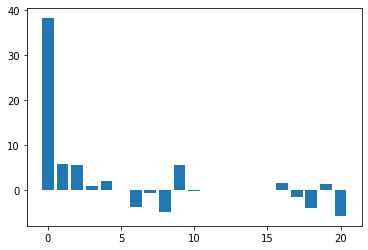

In [117]:
importance = Lasso.coef_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [118]:
features.columns.tolist()

['accommodates',
 'bathrooms',
 'bedrooms',
 'host_is_superhost',
 'room_type_Entire home/apt',
 'room_type_Hotel room',
 'room_type_Private room',
 'room_type_Shared room',
 'Index of Multiple Deprivation (IMD) Score',
 'median_house_price_2020',
 'has_wifi',
 'has_kitchen',
 'has_parking',
 'has_tv',
 'has_washer',
 'has_garden',
 'has_balcony',
 'minutes_to_town',
 'minutes_to_rail',
 'minutes_to_airport',
 'logreviews']

<pre style='color:#000000;background:#ffffff;'>Key Takeaways<span style='color:#808030; '>:</span>

Amenities have an impact on price

Bristol <span style='color:#800000; font-weight:bold; '>and</span> Manchester together need to resampled so theres an equal amount otherwise model together <span style='color:#800000; font-weight:bold; '>is</span> <span style='color:#800000; font-weight:bold; '>not</span> very accurate

Bristol <span style='color:#800000; font-weight:bold; '>and</span> Manchester modelled more accurately themselves however<span style='color:#808030; '>,</span> the result <span style='color:#800000; font-weight:bold; '>is</span> comparable to when an equal sample <span style='color:#800000; font-weight:bold; '>is</span> used<span style='color:#808030; '>.</span>
</pre>
<!--Created using ToHtml.com on 2021-02-04 10:29:24 UTC -->

In [119]:
#we are going to concat our sampled data and then remove duplicates so we have brand new data to test our latest combined model on
Testing_data= pd.concat([sampled_bristol_machester,manchester_bristol_journey])
Testing_data=Testing_data.drop_duplicates(subset='id', keep=False)
Testing_data=Testing_data.drop(columns='logreviews')
Testing_data=Testing_data[(Testing_data['price']<=1000) & (Testing_data['price']>=15)]


Testing_data['logreviews']=np.log(1+ Testing_data['number_of_reviews'])


In [120]:
Testing_data_features=Testing_data.drop(columns=['id','city', 'property_type','geometry',
       'index_right', 'LSOA11CD', 'LSOA11NM','price','number_of_reviews'])

In [121]:
#Testing_data_features_scaled=scaler.fit_transform(X=Testing_data_features)

In [124]:
testing_predict=Lasso.predict(Testing_data_features)

mse= mean_squared_error(Testing_data['price'], testing_predict)
rmse=mse**(1/2)
rmse   #model performing terribly on unseen data

1360843.0120968062

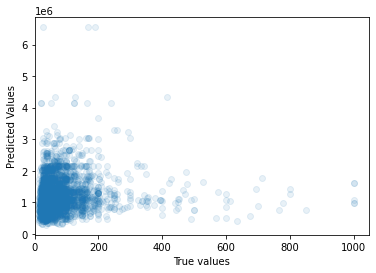

In [125]:
plt.scatter(Testing_data['price'],testing_predict,alpha=0.1)
plt.ylabel("Predicted Values")
plt.xlabel("True values")
plt.xlim(xmin=0)
plt.show()  #underprediction

# Question: Was I wrong to exclude high values when training the model. Model inaccurate at predicting prices higher than £150.                                                        What do we do with extreme prices?                                                                            Is a national model viable? 